In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.rand()

def f(x):
   
    return 3*x**2 - 2*x + 1

In [2]:
f(3)

22

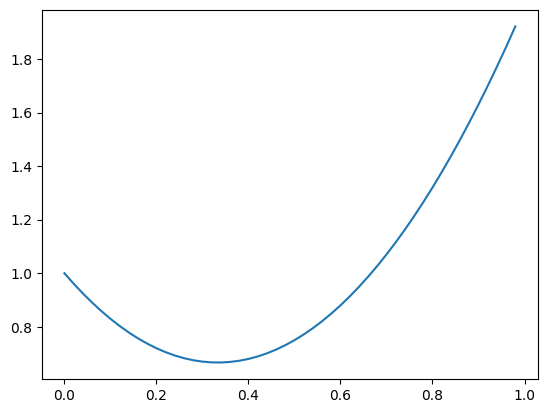

In [3]:
xs = np.arange(0, 1, 0.02)
ys = f(xs)
plt.plot(xs, ys)

From wikipeida:
A function of a real variable $f(x)$ is differentiable at a point $a$ of its domain, if its domain contains an open interval containing $a$ and the limit

$$L = \lim_{h \to 0} \frac{f(a+h)-f(a)}{h}$$


In [4]:
h = 0.0000001
x = -3
(f(x+h) - f(x))/h

-19.99999966528776

In [5]:
class Value:
    
    def __init__(self, data, _children = (), _op =''):
        self.data = data 
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        
    def __repr__ (self):
        return f"Value(data: {self.data})"
        
    def __add__ (self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 
        
        return out

    def __radd__ (self, other):
        return self + other

    def __neg__ (self):
        return self * -1

    def __sub__ (self, other):
        return self + (-other)

    def __rsub__ (self, other):
        return self - other
    
    def __mul__ (self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward 
        
        return out

    def __rmul__ (self, other):
        return self * other

    def __pow__ (self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now" 
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
    
        return out
        
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)

        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        x = self.data
        t = max(0, x)

        out = Value(t, (self, ), 'relu')

        def _backward():
            self.grad += out.grad * (x > 0)
        out._backward = _backward
            
        return out
    
        
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for n in reversed(topo):
            n._backward()


        

In [6]:
class Neuron:
    def __init__ (self, nin):
        self.weights = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(np.random.uniform(-1, 1))

    def __call__ (self, x):
        act = sum((wi*xi for wi, xi in zip(self.weights, x)), self.bias)
        out = act.tanh()
        return out

    def parameters (self):
        return self.weights + [self.bias]

class Layer:
    def __init__ (self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__ (self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters (self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__ (self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

    def __call__ (self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters (self):
        return [p for layer in self.layers for p in layer.parameters()]

    def zero_grad (self):
        for p in n.parameters():
            p.grad = 0.0

x = [1.0, -2.0, 3.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data: 0.7827108021433976)

In [7]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
d
draw_dot(loss)

NameError: name 'draw_dot' is not defined

In [8]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)          
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='SVG', graph_attr={'rankdir' : 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{data %.4f | grad %.4f}" % (n.data, n.grad, ), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
          
    return dot

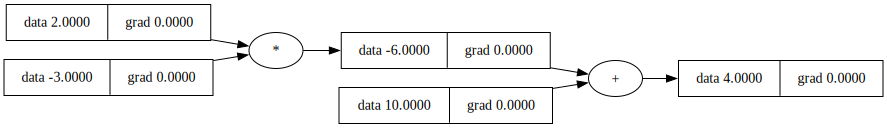

In [10]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

draw_dot(d)

In [ ]:
xs = [
    [2.0 , 3.0, 5.0],
    [3.0 , -1.0, 0.5],
    [0.5 , 1.0, 1.0],
    [1.0 , 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0 , 1.0]



In [ ]:
for k in range(1000):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    n.zero_grad()
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -1 * p.grad

    print(k, loss) if k%100==0 else None

In [ ]:
ypred

In [ ]:
n.layers[0].neurons[0].weights[0].data

In [ ]:
n.parameters()

In [ ]:
draw_dot(loss)